# Geant4 Monte Carlo NIEL Calculation for InP

**Method**: Step-level energy deposition with energy binning.

For each proton step in the thick target:
1. Get proton KE at pre-step point → determines energy bin
2. Get step length dx
3. Sum Lindhard-partitioned KE of all nuclear recoil secondaries → damage_energy
4. NIEL(E) = Σ damage_energy(E) / (ρ × Σ dx(E))

Multiple starting energies populate all energy bins. Below ~0.3 MeV where Geant4's
MSC doesn't produce explicit nuclear recoils, we use the analytical Coulomb NIEL.

**Physics**: QGSP_BIC_HP (Binary Intranuclear Cascade + High Precision neutrons)

In [1]:
import os
import numpy as np

# Geant4 environment — single env var points to all datasets
os.environ['GEANT4_DATA_DIR'] = '/home/vm/geant4-build/build/data'

g4_lib = '/home/vm/geant4-install/lib'
os.environ['LD_LIBRARY_PATH'] = g4_lib + ':' + os.environ.get('LD_LIBRARY_PATH', '')

import geant4_pybind as g4
print(f'Geant4 loaded successfully: {g4.G4Version}')

Geant4 loaded successfully: $Name: geant4-11-03-patch-02 $


In [2]:
# --- Lindhard partition (same as analytical notebook) ---

def lindhard_partition(T_eV, Z1, M1, Z2=None, M2=None):
    """Robinson-Lindhard partition function."""
    if Z2 is None: Z2 = Z1
    if M2 is None: M2 = M1
    a_u = 0.8853
    Z_eff = (Z1**(2/3) + Z2**(2/3))**0.5
    epsilon = (a_u * 0.529 / (Z1 * Z2 * 14.4)) * (M2 / (M1 + M2)) * T_eV
    k_L = 0.1337 * Z1**(1/6) * (Z1 * Z2 / Z_eff)**0.5 * ((M1 + M2) / M2)**1.5 / (M1**0.5)
    g = epsilon + 0.40244 * epsilon**(3/4) + 3.4008 * epsilon**(1/6)
    return 1.0 / (1.0 + k_L * g)

print('lindhard_partition loaded')

lindhard_partition loaded


In [3]:
# --- Geant4 NIEL simulation classes ---

class NIELDetectorConstruction(g4.G4VUserDetectorConstruction):
    """Thick slab of target material for proton stopping."""
    
    def __init__(self, material_name, density_g_cm3, elements, fractions, thickness_cm=5.0):
        super().__init__()
        self.material_name = material_name
        self.density = density_g_cm3
        self.elements = elements
        self.fractions = fractions
        self.thickness = thickness_cm * g4.cm
    
    def Construct(self):
        nist = g4.G4NistManager.Instance()
        self.material = g4.G4Material(
            self.material_name, self.density * g4.g / g4.cm3, len(self.elements))
        for (Z, A, sym), frac in zip(self.elements, self.fractions):
            elem = nist.FindOrBuildElement(Z)
            self.material.AddElement(elem, frac)
        
        world_size = 50.0 * g4.cm
        vacuum = nist.FindOrBuildMaterial('G4_Galactic')
        world_solid = g4.G4Box('World', world_size, world_size, world_size)
        world_log = g4.G4LogicalVolume(world_solid, vacuum, 'World')
        world_phys = g4.G4PVPlacement(None, g4.G4ThreeVector(), world_log, 'World', None, False, 0)
        
        slab_solid = g4.G4Box('Target', 5.0*g4.cm, 5.0*g4.cm, self.thickness/2.0)
        slab_log = g4.G4LogicalVolume(slab_solid, self.material, 'Target')
        g4.G4PVPlacement(None, g4.G4ThreeVector(), slab_log, 'Target', world_log, False, 0)
        return world_phys


class NIELSteppingAction(g4.G4UserSteppingAction):
    """Compute NIEL by binning damage energy vs proton KE at each step.
    
    For each proton step in the target:
    - Proton KE at pre-step → determines energy bin
    - Step length dx → contributes to total path in that bin
    - Damage energy from Lindhard-partitioned recoil secondaries
    - NIEL(E) = total_damage(E) / (density * total_path(E))
    """
    
    def __init__(self, density, energy_bins):
        super().__init__()
        self.density = density
        self.energy_bins = energy_bins
        self.n_bins = len(energy_bins) - 1
        self.damage_per_bin = np.zeros(self.n_bins)
        self.path_per_bin = np.zeros(self.n_bins)
    
    def reset(self):
        self.damage_per_bin[:] = 0
        self.path_per_bin[:] = 0
    
    def UserSteppingAction(self, step):
        volume = step.GetPreStepPoint().GetTouchable().GetVolume()
        if volume.GetName() != 'Target':
            return
        
        track = step.GetTrack()
        if track.GetDefinition().GetParticleName() != 'proton':
            return
        
        proton_KE = step.GetPreStepPoint().GetKineticEnergy() / g4.MeV
        bin_idx = np.searchsorted(self.energy_bins, proton_KE) - 1
        if bin_idx < 0 or bin_idx >= self.n_bins:
            return
        
        dx = step.GetStepLength() / g4.cm
        if dx <= 0:
            return
        
        self.path_per_bin[bin_idx] += dx
        
        secondaries = step.GetSecondaryInCurrentStep()
        if secondaries is None or len(secondaries) == 0:
            return
        
        damage = 0.0
        for sec in secondaries:
            sec_particle = sec.GetDefinition()
            Z_sec = int(sec_particle.GetAtomicNumber())
            A_sec = int(sec_particle.GetAtomicMass())
            KE = sec.GetKineticEnergy() / g4.MeV
            if KE <= 0 or Z_sec <= 0 or A_sec <= 0:
                continue
            T_eV = KE * 1e6
            L = lindhard_partition(T_eV, Z_sec, float(A_sec), 32.0, 73.0)
            damage += KE * L
        
        self.damage_per_bin[bin_idx] += damage


class NIELEventAction(g4.G4UserEventAction):
    def __init__(self, stepping):
        super().__init__()
        self.stepping = stepping
    def EndOfEventAction(self, event):
        pass


class NIELPrimaryGenerator(g4.G4VUserPrimaryGeneratorAction):
    """Pencil beam of protons along z-axis."""
    
    def __init__(self, energy_MeV=100.0):
        super().__init__()
        self.gun = g4.G4ParticleGun(1)
        proton = g4.G4ParticleTable.GetParticleTable().FindParticle('proton')
        self.gun.SetParticleDefinition(proton)
        self.gun.SetParticleEnergy(energy_MeV * g4.MeV)
        self.gun.SetParticleMomentumDirection(g4.G4ThreeVector(0, 0, 1))
        self.gun.SetParticlePosition(g4.G4ThreeVector(0, 0, -25.0*g4.cm))
    
    def set_energy(self, energy_MeV):
        self.gun.SetParticleEnergy(energy_MeV * g4.MeV)
    
    def GeneratePrimaries(self, event):
        self.gun.GeneratePrimaryVertex(event)


class NIELActionInitialization(g4.G4VUserActionInitialization):
    def __init__(self, density, energy_bins, initial_energy=200.0):
        super().__init__()
        self.density = density
        self.energy_bins = energy_bins
        self.initial_energy = initial_energy
        self.stepping = None
        self.generator = None
    
    def Build(self):
        self.stepping = NIELSteppingAction(self.density, self.energy_bins)
        self.generator = NIELPrimaryGenerator(self.initial_energy)
        self.SetUserAction(self.generator)
        self.SetUserAction(NIELEventAction(self.stepping))
        self.SetUserAction(self.stepping)


print('Geant4 NIEL classes defined')

Geant4 NIEL classes defined


In [4]:
# --- Run NIEL simulation for InP ---

from ase.data import atomic_masses, atomic_numbers

# material definition: InP
formula = 'InP'
density = 4.6694  # g/cm³ from DFT
elements = [(49, 115, 'In'), (15, 31, 'P')]
m_In = atomic_masses[49]
m_P = atomic_masses[15]
total_mass = m_In + m_P
mass_fractions = [m_In / total_mass, m_P / total_mass]

# energy bins for NIEL(E)
energy_bin_edges = np.logspace(np.log10(0.1), np.log10(250.0), 60)
thickness_cm = 5.0

print(f'material: {formula}, density={density:.4f} g/cm³')
print(f'target: {thickness_cm} cm thick InP slab')
print(f'NIEL bins: {len(energy_bin_edges)-1} bins, {energy_bin_edges[0]:.2f}–{energy_bin_edges[-1]:.0f} MeV')
print(f'physics: QGSP_BIC_HP\n')

# --- Create RunManager (singleton) ---
runManager = g4.G4RunManagerFactory.CreateRunManager(g4.G4RunManagerType.Serial)

det = NIELDetectorConstruction(formula, density, elements, mass_fractions, thickness_cm)
runManager.SetUserInitialization(det)

physics = g4.QGSP_BIC_HP()
runManager.SetUserInitialization(physics)

actions = NIELActionInitialization(density, energy_bin_edges, 200.0)
runManager.SetUserInitialization(actions)

ui = g4.G4UImanager.GetUIpointer()
ui.ApplyCommand('/run/verbose 0')
ui.ApplyCommand('/event/verbose 0')
ui.ApplyCommand('/tracking/verbose 0')

runManager.Initialize()
print('RunManager initialized\n')

# --- Run protons at multiple starting energies ---
# Higher energies populate more bins as protons slow down
run_configs = [
    (200.0, 100000),  # fills bins from 0 to 200 MeV
    (100.0,  50000),
    (50.0,   30000),
    (20.0,   30000),
    (10.0,   30000),
    (5.0,    30000),
    (2.0,    30000),
    (1.0,    30000),
    (0.5,    30000),
]

for E_start, n_protons in run_configs:
    actions.generator.set_energy(E_start)
    print(f'  {n_protons:>6d} protons @ {E_start:6.1f} MeV ...', end=' ', flush=True)
    runManager.BeamOn(n_protons)
    print('done')

# --- Compute NIEL from accumulated data ---
s = actions.stepping
bin_centers = np.sqrt(energy_bin_edges[:-1] * energy_bin_edges[1:])

niel_g4 = np.zeros(s.n_bins)
for i in range(s.n_bins):
    if s.path_per_bin[i] > 0:
        niel_g4[i] = s.damage_per_bin[i] / (density * s.path_per_bin[i])

energies_MeV = bin_centers
mask = niel_g4 > 0

print(f'\nDone! Non-zero NIEL at {mask.sum()}/{s.n_bins} energy bins.')
print(f'\n{"E (MeV)":>10} {"NIEL (MeV·cm²/g)":>18}')
for E_target in [0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0]:
    idx = np.argmin(np.abs(bin_centers - E_target))
    print(f'{bin_centers[idx]:10.3f} {niel_g4[idx]:18.4e}')

material: InP, density=4.6694 g/cm³
target: 5.0 cm thick InP slab
NIEL bins: 59 bins, 0.10–250 MeV
physics: QGSP_BIC_HP


**************************************************************
 Geant4 version Name: geant4-11-03-patch-02    (25-April-2025)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

<<< Geant4 Physics List simulation engine: QGSP_BIC_HP

@@@ G4ParticleHPInelasticData instantiated for particle neutron data directory variable is G4NEUTRONHPDATA pointing to /home/vm/geant4-build/build/data/G4NDL4.7.1
RunManager initialized

  100000 protons @  200.0 MeV ... =======================================================================
======                 Electromagnetic Physi

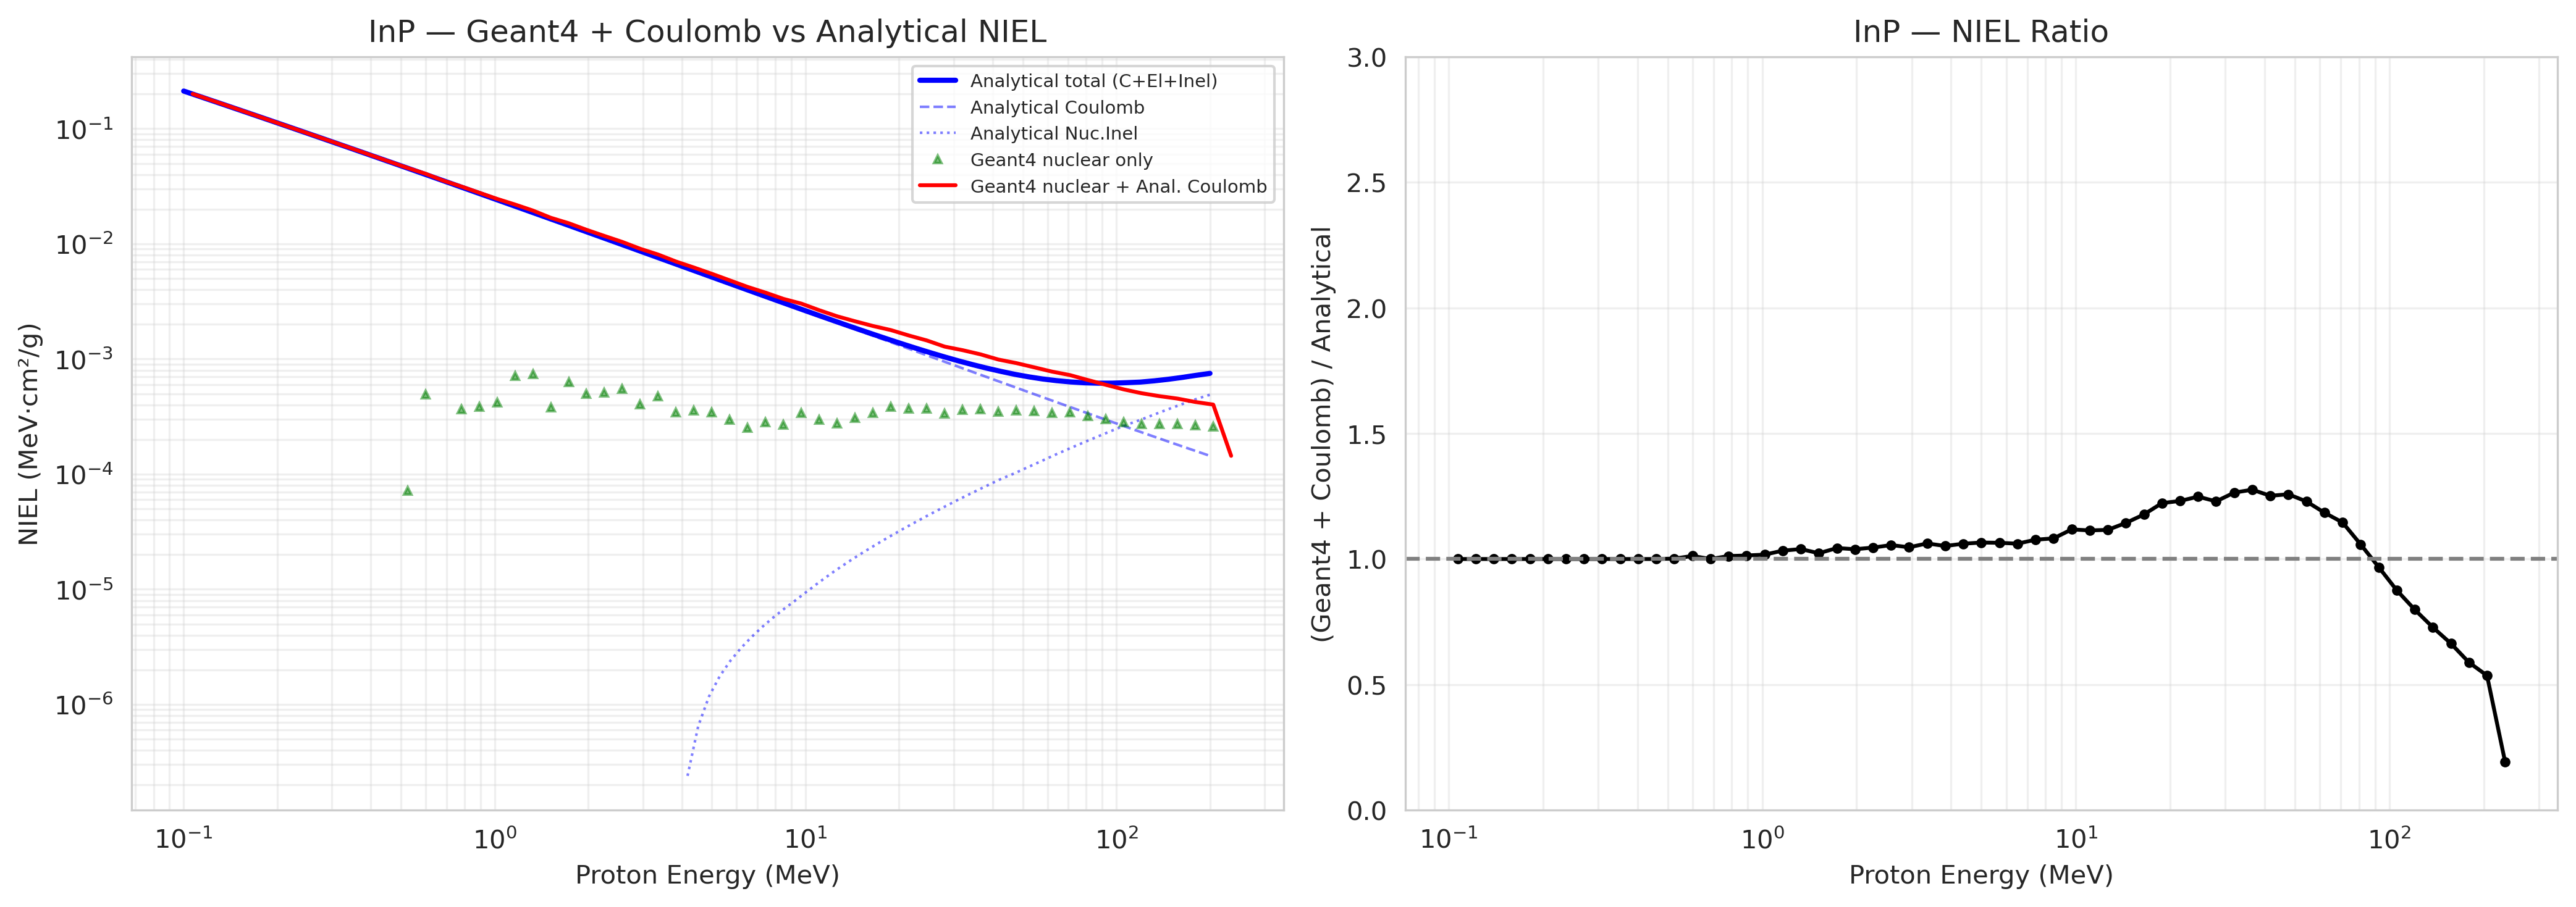


   E (MeV)   Analytical   G4+Coulomb   G4 nuclear    Ratio
       0.1   2.1227e-01   2.0046e-01   0.0000e+00     0.94
       0.5   4.7697e-02   4.5655e-02   7.1775e-05     0.96
       1.0   2.4558e-02   2.4579e-02   4.2010e-04     1.00
       2.0   1.2591e-02   1.3238e-02   4.9615e-04     1.05
       5.0   5.1536e-03   5.4919e-03   3.4137e-04     1.07
      10.0   2.6257e-03   3.0257e-03   3.3842e-04     1.15
      20.0   1.3834e-03   1.7819e-03   3.8231e-04     1.29
      50.0   7.1578e-04   9.2125e-04   3.5738e-04     1.29
     100.0   6.1862e-04   5.4440e-04   2.8224e-04     0.88
     200.0   7.5021e-04   4.0194e-04   2.5773e-04     0.54


In [5]:
# --- Compare Geant4 vs analytical ---

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 300

# load analytical results
analytical_file = os.path.join(os.path.dirname(os.getcwd()), 'omere_inputs', f'{formula}_NIEL.dat')
data_a = np.loadtxt(analytical_file)
E_a = data_a[:, 0]
niel_total_a = data_a[:, 1]
niel_coul_a = data_a[:, 2]
niel_nel_a = data_a[:, 3]
niel_ninel_a = data_a[:, 4]

# Geant4 captures nuclear elastic + inelastic via explicit recoil secondaries,
# but Coulomb scattering is handled by MSC which doesn't produce recoil secondaries.
# combine geant4 nuclear + analytical coulomb for total niel
niel_coulomb_interp = np.interp(bin_centers, E_a, niel_coul_a)
niel_combined = niel_coulomb_interp + niel_g4  # analytical Coulomb + Geant4 nuclear

# --- Plots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# plot 1: Geant4+Coulomb vs analytical
ax = axes[0]
ax.loglog(E_a, niel_total_a, 'b-', linewidth=2, label='Analytical total (C+El+Inel)')
ax.loglog(E_a, niel_coul_a, 'b--', linewidth=1, alpha=0.5, label='Analytical Coulomb')
m_inel = niel_ninel_a > 0
ax.loglog(E_a[m_inel], niel_ninel_a[m_inel], 'b:', linewidth=1, alpha=0.5, label='Analytical Nuc.Inel')

m_g4 = niel_g4 > 0
ax.loglog(bin_centers[m_g4], niel_g4[m_g4], 'g^', markersize=3, alpha=0.5, label='Geant4 nuclear only')
ax.loglog(bin_centers, niel_combined, 'r-', linewidth=1.5, label='Geant4 nuclear + Anal. Coulomb')

ax.set_xlabel('Proton Energy (MeV)')
ax.set_ylabel('NIEL (MeV·cm²/g)')
ax.set_title(f'{formula} — Geant4 + Coulomb vs Analytical NIEL')
ax.legend(fontsize=7)
ax.grid(True, which='both', alpha=0.3)

# plot 2: ratio
ax = axes[1]
niel_a_interp = np.interp(bin_centers, E_a, niel_total_a)
ratio = np.where(niel_a_interp > 0, niel_combined / niel_a_interp, 0)
valid = niel_a_interp > 0
ax.semilogx(bin_centers[valid], ratio[valid], 'ko-', markersize=3)
ax.axhline(1.0, color='gray', linestyle='--')
ax.set_xlabel('Proton Energy (MeV)')
ax.set_ylabel('(Geant4 + Coulomb) / Analytical')
ax.set_title(f'{formula} — NIEL Ratio')
ax.set_ylim(0, 3)
ax.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()

# comparison table
print(f'\n{"E (MeV)":>10} {"Analytical":>12} {"G4+Coulomb":>12} {"G4 nuclear":>12} {"Ratio":>8}')
for E_sel in [0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 200]:
    idx = np.argmin(np.abs(bin_centers - E_sel))
    niel_a_val = np.interp(E_sel, E_a, niel_total_a)
    niel_comb_val = niel_combined[idx]
    niel_nuc_val = niel_g4[idx]
    r = niel_comb_val / niel_a_val if niel_a_val > 0 else 0
    print(f'{E_sel:10.1f} {niel_a_val:12.4e} {niel_comb_val:12.4e} {niel_nuc_val:12.4e} {r:8.2f}')

In [6]:
# --- Save Geant4 NIEL results ---

output_dir = os.path.join(os.path.dirname(os.getcwd()), 'omere_inputs')
g4_file = os.path.join(output_dir, f'{formula}_NIEL_Geant4.dat')

with open(g4_file, 'w') as f:
    f.write(f'# niel for {formula} (protons), geant4 monte carlo + analytical coulomb\n')
    f.write(f'# density {density:.4f} g/cm3 (dft pbe+d3 vc-relaxed)\n')
    f.write(f'# nuclear channels: geant4 qgsp_bic_hp, step-level energy binning\n')
    f.write(f'# coulomb channel: analytical screened rutherford + mott correction\n')
    f.write(f'# target {thickness_cm} cm slab, multi-energy proton runs\n')
    f.write(f'# lindhard robinson partition\n')
    f.write(f'# displacement thresholds p 8.7 eV, in 8.8 eV\n')
    f.write(f'#\n')
    f.write(f'# energy_mev\tniel_total\tniel_g4_nuclear\tniel_coulomb\n')
    for i in range(len(bin_centers)):
        f.write(f'{bin_centers[i]:.6e}\t{niel_combined[i]:.6e}\t{niel_g4[i]:.6e}\t{niel_coulomb_interp[i]:.6e}\n')

print(f'saved: {g4_file}')
print(f'{len(bin_centers)} energy points written')

saved: /home/vm/LUMENS-PV/omere_inputs/InP_NIEL_Geant4.dat
59 energy points written
